In [3]:
%matplotlib inline

 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)
import joblib
from skimage.io import imread
from skimage.transform import resize

In [4]:
data_path = os.getcwd()

#data_path_car = 'C:\\Users\\zoomt\\Downloads\\vehicles\\vehicles\\KITTI_extracted'
data_path_car = 'C:\\Users\\zoomt\\Desktop\\Programs\\MACHINELEARNING\\CS334-AML\\FinalProject\\vehicles\\vehicles\\KITTI_extracted'
#data_path_not_car = 'C:\\Users\\zoomt\\Downloads\\non-vehicles\\non-vehicles\\Extras'
data_path_not_car = 'C:\\Users\\zoomt\\Desktop\\Programs\\MACHINELEARNING\\CS334-AML\\FinalProject\\non-vehicles\\non-vehicles\\Extras'


data = dict()
data['label'] = []
data['filename'] = []
data['data'] = []  

for file in os.listdir(data_path_car):
    if file[-3:] in {'jpg', 'png'}:
        im = imread(os.path.join(data_path_car, file))
        data['label'].append("vehicle")
        data['filename'].append(file)
        data['data'].append(im)
        
for file in os.listdir(data_path_not_car):
    if file[-3:] in {'jpg', 'png'}:
        im = imread(os.path.join(data_path_not_car, file))
        data['label'].append("non-vehicle")
        data['filename'].append(file)
        data['data'].append(im)

In [5]:
from collections import Counter
  
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  11034
keys:  ['label', 'filename', 'data']
image shape:  (64, 64, 3)
labels: ['non-vehicle' 'vehicle']


Counter({'vehicle': 5966, 'non-vehicle': 5068})

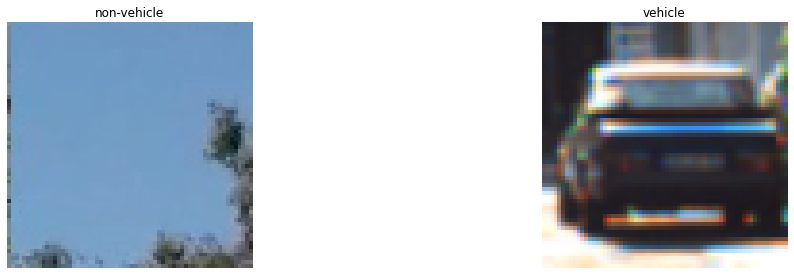

In [6]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

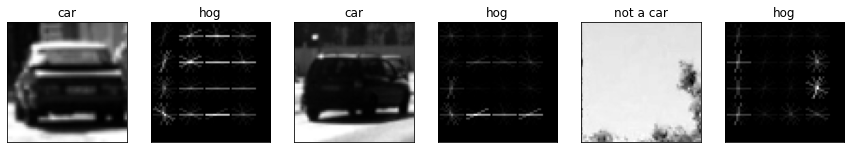

In [9]:
from skimage.feature import hog
from skimage.io import imread
 
car = imread('C:\\Users\\zoomt\\Desktop\\Programs\\MACHINELEARNING\\CS334-AML\\FinalProject\\vehicles\\vehicles\\KITTI_extracted\\1.png', as_gray=True)
car2 = imread('C:\\Users\\zoomt\\Desktop\\Programs\\MACHINELEARNING\\CS334-AML\\FinalProject\\vehicles\\vehicles\\KITTI_extracted\\2.png', as_gray=True)
not_car1 = imread('C:\\Users\\zoomt\\Desktop\\Programs\\MACHINELEARNING\\CS334-AML\\FinalProject\\non-vehicles\\non-vehicles\\Extras\\extra1.png', as_gray=True)

car1_hog, car1_hog_img = hog(
    car, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
car2_hog, car2_hog_img = hog(
    car2, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
not_car_hog, not_car_hog_img = hog(
    not_car1, pixels_per_cell=(14,14), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True, 
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,6)
fig.set_size_inches(15,15)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(car, cmap='gray')
ax[0].set_title('car')
ax[1].imshow(car1_hog_img, cmap='gray')
ax[1].set_title('hog')
ax[2].imshow(car2, cmap='gray')
ax[2].set_title('car')
ax[3].imshow(car2_hog_img, cmap='gray')
ax[3].set_title('hog')
ax[4].imshow(not_car1, cmap='gray')
ax[4].set_title('not a car')
ax[5].imshow(not_car_hog_img, cmap='gray')
ax[5].set_title('hog')
plt.show()


In [10]:
X = data['data']
y = data['label']

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)

In [19]:
NN = MLPClassifier(verbose='true')
%time NN.fit(X_train_prepared, y_train)

Iteration 1, loss = 0.21937566
Iteration 2, loss = 0.07385553
Iteration 3, loss = 0.04949935
Iteration 4, loss = 0.03575445
Iteration 5, loss = 0.02728470
Iteration 6, loss = 0.02159250
Iteration 7, loss = 0.01624145
Iteration 8, loss = 0.01255377
Iteration 9, loss = 0.01003543
Iteration 10, loss = 0.00801443
Iteration 11, loss = 0.00654557
Iteration 12, loss = 0.00555291
Iteration 13, loss = 0.00466514
Iteration 14, loss = 0.00399054
Iteration 15, loss = 0.00336584
Iteration 16, loss = 0.00290776
Iteration 17, loss = 0.00256139
Iteration 18, loss = 0.00229294
Iteration 19, loss = 0.00205402
Iteration 20, loss = 0.00179790
Iteration 21, loss = 0.00163010
Iteration 22, loss = 0.00148372
Iteration 23, loss = 0.00133784
Iteration 24, loss = 0.00122478
Iteration 25, loss = 0.00116301
Iteration 26, loss = 0.00104019
Iteration 27, loss = 0.00095617
Iteration 28, loss = 0.00088946
Iteration 29, loss = 0.00082376
Iteration 30, loss = 0.00076724
Iteration 31, loss = 0.00072646
Iteration 32, los

MLPClassifier(verbose='true')

In [20]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)
y_pred = NN.predict(X_test_prepared)
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

Percentage correct:  98.91255097417309
